## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

#### Disable auto-scroll

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from tqdm import *
%matplotlib inline

  
def get_sample_chess_images():        
    # Placeholder to hold the sample chess images
    samples = []
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    # Loop through and read all the sample images
    for fname in images:
        samples.append(cv2.imread(fname))
        
    return samples
  
def calibrate_camera(sample_chess_images, num_x=9, num_y=6):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((num_x*num_y,3), np.float32)
    objp[:,:2] = np.mgrid[0:num_x,0:num_y].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    print('Calibrating camera...')

    # Step through the list and search for chessboard corners
    for img in tqdm(sample_chess_images):        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (num_x, num_y),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners (Uncomment the below lines if you want to visualize)
            #img = cv2.drawChessboardCorners(img, (num_x, num_y), corners, ret)
            #cv2.imshow('img', img)
            #cv2.waitKey(500)
                
    # Do camera calibration given object points and image points
    img_size = (sample_chess_images[0].shape[1], sample_chess_images[0].shape[0])
        
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Structure the calibration data
    calibration_data = {}
    calibration_data["mtx"] = mtx
    calibration_data["dist"] = dist

    return dist_pickle

def undistort(calibration_data, image):
    mtx = calibration_data['mtx']
    dist = calibration_data['dist']
    return cv2.undistort(image, mtx, dist, None, mtx)

def test_undistort(calibration_data, img_path):
    image = mpimg.imread(img_path)
    undist = undistort(calibration_data, image)
    display_images(image, undist, 'Undistorted')

def display_images(orig, proc, title=''):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(orig)
    if title=='':        
        ax1.set_title('', fontsize=50)
    else:
        ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(proc, cmap='gray')
    ax2.set_title(title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    plt.show()
    
def display_image(img, title=''):
    f, (ax1) = plt.subplots(1, 1)
    f.tight_layout()
    ax1.imshow(img)        
    ax1.set_title(title, fontsize=20)    

    plt.show()

## Compute the camera calibration using chessboard images

Retrieving calibration from disk


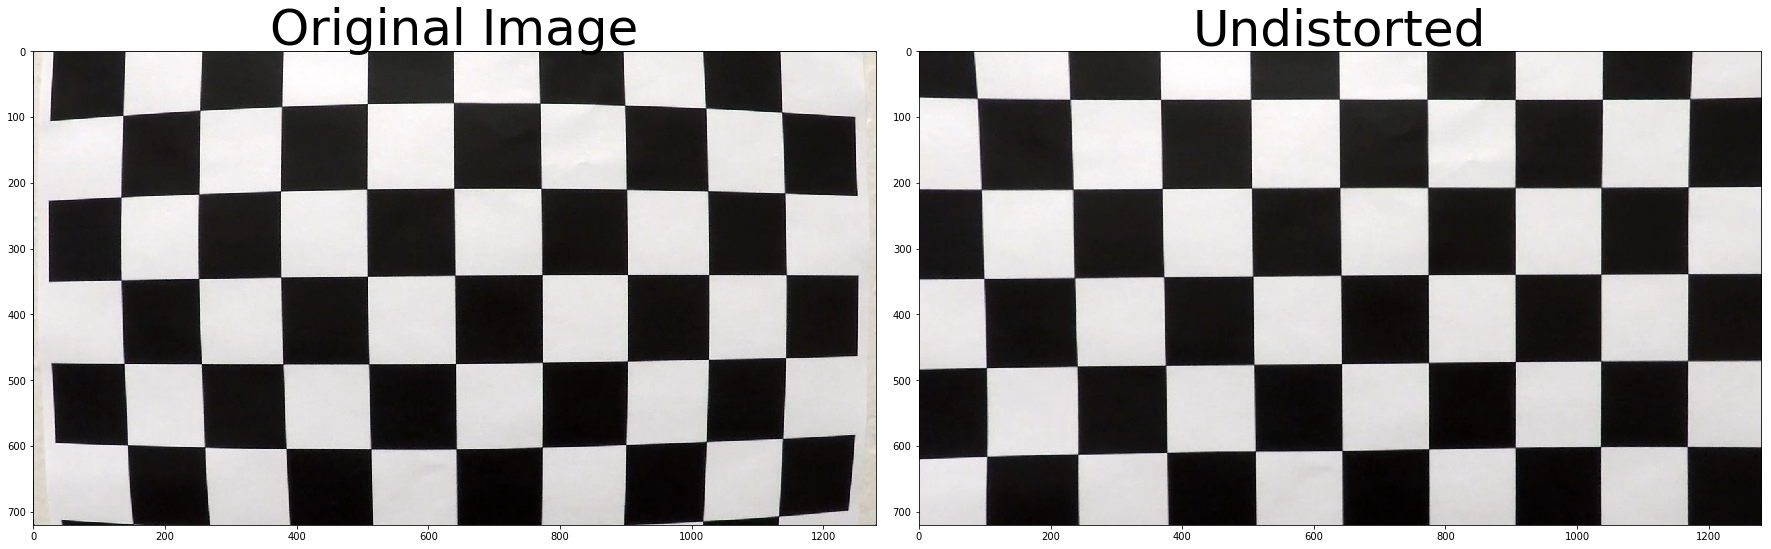

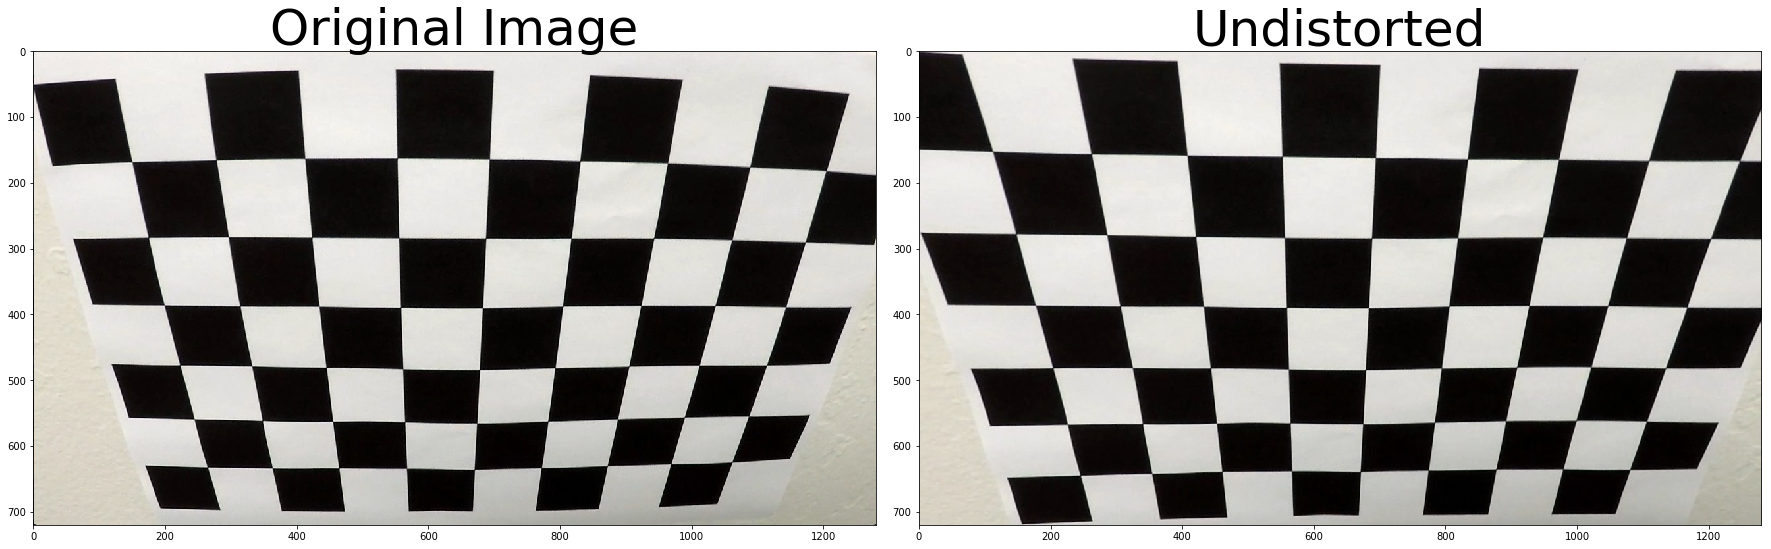

In [3]:
CALIBRATION = 'camera_cal/calibration.p'

# If calibration data already exists then skip the calibration steps
if os.path.exists(CALIBRATION):
    print('Retrieving calibration from disk')
    calibration_data = pickle.load(open(CALIBRATION, 'rb'))
else:
    # Build sample chess board images for calibration
    samples = get_sample_chess_images()

    # Calibrate the camera using these samples
    calibration_data = calibrate_camera(samples)

    # Preserve this camera's calibration data
    pickle.dump(calibration_data, open(CALIBRATION, "wb"))

# Test calibration by undistorting
test_undistort(calibration_data, 'camera_cal/test1.jpg')
test_undistort(calibration_data, 'camera_cal/test2.jpg')

## Apply a distortion correction to raw images

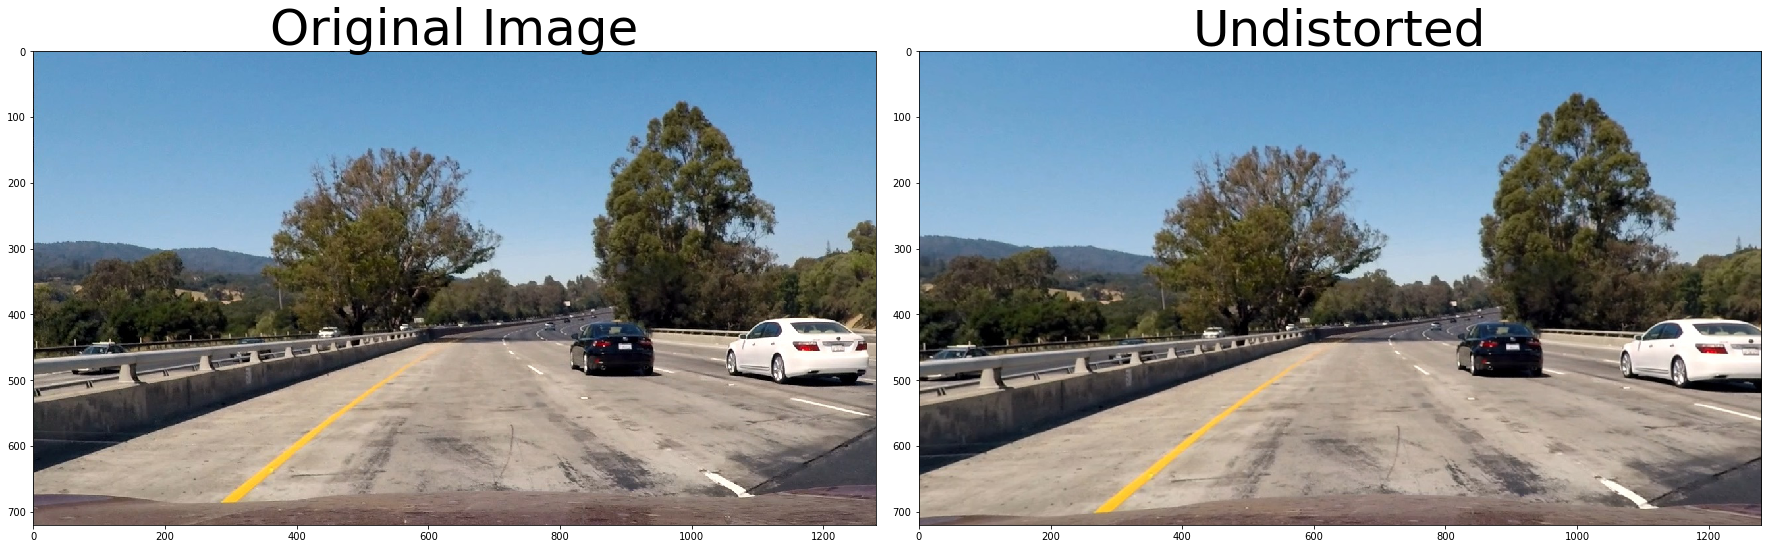

In [4]:
test_undistort(calibration_data, 'test_images/test1.jpg')

## Threshold the image using color transforms, gradients, direction

In [5]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    gray= canny(gray, 100, 250)
    gray= gaussian_blur(gray, 5)
    
    if orient == 'x':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        
    if orient == 'y':
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
            
    
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    
    return grad_binary

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    sobelxy = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    
    scaled_sobel = np.uint8(255*sobelxy/np.max(sobelxy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    dir = np.arctan2(sobel_y, sobel_x)
    
    dir_binary = np.zeros_like(dir)
    dir_binary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1    
    
    
    return dir_binary

## Threshold

In [6]:
img = mpimg.imread('test_images/test1.jpg')
img = undistort(calibration_data, img)

# Edit this function to create your own pipeline.
# def apply_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
def apply_threshold(img, s_thresh=(20, 255), sx_thresh=(10, 255)):

    ksize = 15
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize, ) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    color_binary = sxbinary
        
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(10, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    
    # Get the RGB channels individually
    if len(img.shape) > 2 and img.shape[2] == 4:
        r, g, b, a = cv2.split(img)
    else:
        r, g, b = cv2.split(img)

    
    # Empty channel
    null_channel = np.zeros_like(s_channel)

    # Detect yellow color
    yellow = np.zeros_like(r)
    yellow[( (r>150)&(g>130)&(b>60) & (b<120) )] = 1
    
    # Detect white color
    white = np.zeros_like(r)
    white[( (r>150)&(g>150)&(b>150) )] = 1
       
    detection = np.dstack((yellow, white, null_channel))   
    
    detect = np.zeros_like(s_channel)
    # Yellow or White
    detect[( ((yellow == 1) & (s_binary == 1)) | (( white == 1 ) & (sxbinary == 1)) |
           ((gradx == 0) & (grady == 0) & ((mag_binary == 1) & (dir_binary == 1))) )] = 1
#     detect[( ((yellow == 1) & (s_binary == 1)) | (( white == 1 ) & (sxbinary == 1)) )] = 1
    color_binary = detect
    
    
    return color_binary

# result = apply_threshold(img)

# display_images(img, result, 'Pipeline Result')


# # Choose a Sobel kernel size
# ksize = 15 # Choose a larger odd number to smooth gradient measurements

# gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 255))
# grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 255))
# mag_binary = mag_thresh(img, sobel_kernel=ksize, thresh=(10, 255))
# dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

# combined = np.zeros_like(dir_binary)
# # combined[((gradx == 1) & (grady == 1) | ((mag_binary == 1) & (dir_binary == 1)))] = 1
# combined[((gradx == 0) & (grady == 0) & ((mag_binary == 1) & (dir_binary == 1)))] = 1

# # Display the results
# display_images(img, gradx, 'Gradient X')
# display_images(img, grady, 'Gradient Y')
# display_images(img, mag_binary, 'Magnitude of gradient')
# display_images(img, dir_binary, 'Direction of gradient')
# display_images(img, combined, 'combined')

## Lane detector

In [14]:
from os import walk
import matplotlib

class LaneDetector():
    def __init__(self):
        # Initialize
        self.left_fit = []
        self.right_fit = []
               
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        
    def warp(self, img, offset=200):
        # Image dimension
        x = img.shape[1]
        y = img.shape[0]

        x_mid = x/2

        src = np.float32([
                [x_mid - 0.2 * x_mid, 0.7 * y],
                [x_mid + 0.2 * x_mid, 0.7 * y],
                [x_mid + 0.5 * x_mid, 0.9 * y],
                [x_mid - 0.5 * x_mid, 0.9 * y]])


        dst = np.float32([
                [offset, offset],
                [x - offset, offset],
                [x - offset, y],
                [offset, y]])

        # Computing the perspective transform
        M = cv2.getPerspectiveTransform(src, dst)

        # To do the reverse
        Minv = cv2.getPerspectiveTransform(dst, src)

        # Do the actual transformation - using linear interpolation
        warped = cv2.warpPerspective(img, M, (x, y), flags=cv2.INTER_LINEAR)

        return warped, Minv

    def fit_lane_lines(self, binary_warped, left_fit, right_fit):
        if len(left_fit):
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            margin = 100
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

            # Again, extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            # Create an image to draw on and an image to show the selection window
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            window_img = np.zeros_like(out_img)
            # Color in left and right line pixels
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
            left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
            left_line_pts = np.hstack((left_line_window1, left_line_window2))
            right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
            right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
            right_line_pts = np.hstack((right_line_window1, right_line_window2))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
            cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
            result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

            return left_fit, right_fit 
        else:    
            # Assuming you have created a warped binary image called "binary_warped"
            # Take a histogram of the bottom half of the image
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
            # Create an output image to draw on and  visualize the result
            out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
            # Find the peak of the left and right halves of the histogram
            # These will be the starting point for the left and right lines
            midpoint = np.int(histogram.shape[0]//2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

            # Choose the number of sliding windows
            nwindows = 9
            # Set height of windows
            window_height = np.int(binary_warped.shape[0]/nwindows)
            # Identify the x and y positions of all nonzero pixels in the image
            nonzero = binary_warped.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Current positions to be updated for each window
            leftx_current = leftx_base
            rightx_current = rightx_base
            # Set the width of the windows +/- margin
            margin = 100
            # Set minimum number of pixels found to recenter window
            minpix = 50
            # Create empty lists to receive left and right lane pixel indices
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = binary_warped.shape[0] - (window+1)*window_height
                win_y_high = binary_warped.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Draw the windows on the visualization image
                cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
                cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds] 

            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

            return left_fit, right_fit
        
    def draw_lanes_on_image(self, image, warped, ploty, left_fit, right_fit, Minv):        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

        # If the image has a transparency channel 
        if len(image.shape) > 2 and image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)    

        return result
    
    def generate_ploty(self, warped):
        # Generate x and y values for plotting
        return np.linspace(0, warped.shape[0]-1, warped.shape[0])
    
    def generate_plot_data(self, ploty, left_fit, right_fit):                
        leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        return leftx, rightx
        
    def measure_curvature(self, ploty, leftx, rightx):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.min(ploty)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/1000 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        return left_curverad, right_curverad

    def measure_offset(self, img, ploty, left_fit, right_fit):
        # meters per pixel in x dimension
        xm_per_pix = 3.7/1000 
        y = np.min(ploty)

        left_lane = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
        right_lane = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
        
        # Calculate the average mid-point of the lane
        lane_center = (right_lane + left_lane) / 2
        
        print(lane_center)
        
        # Position of the camera (assuming this is center of the car)
        image_center = img.shape[1] / 2

        offset = (image_center - lane_center) * xm_per_pix

        return offset
    
    def write_info(self, image, left_rad, right_rad, offset):
        # Constants
        FONT = cv2.FONT_HERSHEY_SIMPLEX
        WHITE = (255, 255, 255)
                
        # Compute the mean radius
        mean_rad = (left_rad + right_rad) // 2
        
        rad_text = 'Radius of Curvature = {0:g}(m)'.format(mean_rad)
        off_text = 'Vehicle is {0:.2f}m left of center'.format(offset)
        
        img = cv2.putText(image, rad_text, (25, 60), FONT, 2, WHITE, 3)
        img = cv2.putText(image, off_text, (25, 150), FONT, 2, WHITE, 3)
        
        
        return img

                        
    def process(self, image):
        left_fit = self.left_fit
        right_fit = self.right_fit
        
        # Remove any radial distortion
        inp = undistort(calibration_data, image)

        # Apply thresholding
        img = apply_threshold(inp)
        
        # Do Perspective transform
        img, Minv = self.warp(img)
        
        try:
            left_fit, right_fit = self.fit_lane_lines(img, left_fit, right_fit)
        except:
            print('Cannot find a fit')
                        
        # Generate plot y
        ploty = self.generate_ploty(img)
                                             
        # Draw on the image
        img = self.draw_lanes_on_image(inp, img, ploty, left_fit, right_fit, Minv)
        
        # Generate plot data
        leftx, rightx = self.generate_plot_data(ploty, left_fit, right_fit)
        
        # Measure the curvature
        left_rad, right_rad = self.measure_curvature(ploty, leftx, rightx)
        
        # Measure offset from center
        offset = self.measure_offset(img, ploty, left_fit, right_fit)
                        
        # Write the curvature and offset to the image
        img = self.write_info(img, left_rad, right_rad, offset)
        
        # Preserve
        self.left_fit = left_fit
        self.right_fit = right_fit
        
        self.radius_of_curvature = (left_rad, right_rad)
        self.line_base_pos = offset
        
        return img
   



719.966766843


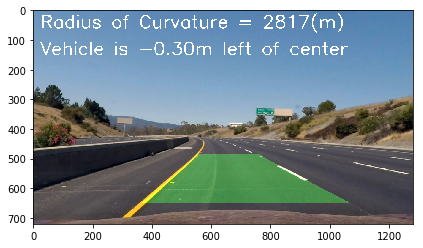

698.851503482


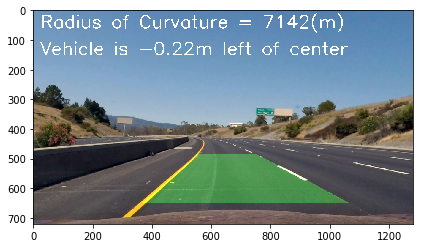

706.998342482


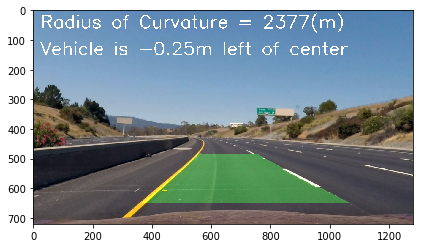

In [15]:
lane_detector = LaneDetector()
        
# for sample in gen_sample('test_images/proj'):
#     print(sample)
#     inp = mpimg.imread(sample)
    
#     out = lane_detector.process(inp)

#     display_image(out)


# #11, 12, 13

list = ['0', '1', '2']
path = 'test_images/proj/out_{}.jpg'

for sample in list:
    inp = mpimg.imread(path.format(sample))
    out = lane_detector.process(inp)
    display_image(out)

## Running the pipeline on a video

In [58]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Destination where the output video will get saved
OUTPUT = 'output_videos/output.mp4'

# Get the clip from input video
clip = VideoFileClip('project_video.mp4')

# Process the clip
lane_detector = LaneDetector()
processed_clip = clip.fl_image(lane_detector.process)
# processed_clip = clip.fl_image(save_image)

# Write it as output
%time processed_clip.write_videofile(OUTPUT, audio=False)

[MoviePy] >>>> Building video output_videos/output.mp4
[MoviePy] Writing video output_videos/output.mp4


100%|██████████████████████████████████████████████████████████▉| 1260/1261 [33:10<00:01,  1.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output.mp4 

Wall time: 33min 14s


In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(OUTPUT))